04루 1183


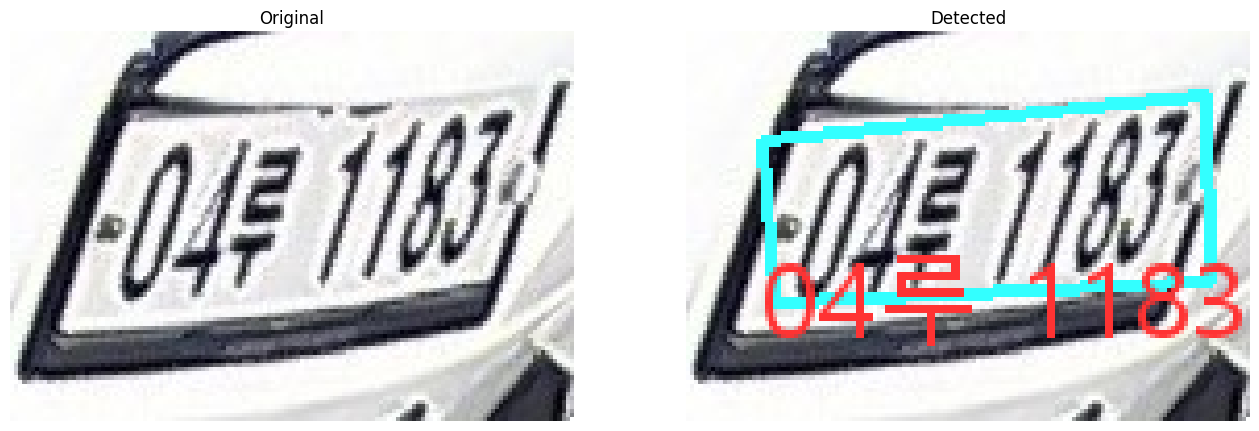

In [2]:
import io
import time
import numpy as np
import platform
import re
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt
import cv2
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials

def put_text(image, text, x, y, color=(255, 51, 51), font_size=25):
    if type(image) == np.ndarray:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    font_path = 'AppleGothic.ttf' if platform.system() == 'Darwin' else 'malgun.ttf'
    image_font = ImageFont.truetype(font_path, font_size)
    draw = ImageDraw.Draw(image)
    draw.text((x, y), text, font=image_font, fill=color)
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

def clean_text(text):
    text = re.sub(r'^[^\w가-힣]+|[^\w가-힣]+$', '', text)
    match = re.search(r'(.*[가-힣]\d{4})', text)
    return match.group(1) if match else text

def display_and_save_results(titles, images, text_path, image_path, detected_text):
    # 텍스트 파일 저장
    with open(text_path, 'w', encoding='utf-8') as f:
        f.write(detected_text)
    
    # 이미지 표시 및 저장을 한 번에 처리
    fig, axes = plt.subplots(1, len(images), figsize=(16, 10))
    for ax, title, img in zip(axes, titles, images):
        if len(img.shape) >= 3:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    
    plt.savefig(image_path)
    plt.show()

# Azure 설정
SUBSCRIPTION_KEY = "1Euazo0zLblXafo9Dpv8ewrEjrQNQqNN4xXiqkUNZ7GnoAzPAYXDJQQJ99BBACYeBjFXJ3w3AAAFACOGxSKh"
ENDPOINT_URL = "https://computervision6b037.cognitiveservices.azure.com/"
computervision_client = ComputerVisionClient(ENDPOINT_URL, CognitiveServicesCredentials(SUBSCRIPTION_KEY))

# 이미지 처리
path = r"C:\Users\EL0014\Desktop\car_test2_lc.jpg"
imageData = open(path, "rb").read()
sbuf = io.BytesIO(imageData)

response = computervision_client.read_in_stream(sbuf, raw=True)
operationLocation = response.headers["Operation-Location"]
operationID = operationLocation.split("/")[-1]

# OCR 결과 대기
while True:
    read_result = computervision_client.get_read_result(operationID)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

if read_result.status == OperationStatusCodes.succeeded:
    img_array = np.fromfile(path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    roi_img = img.copy()
    
    detected_texts = []  # 검출된 텍스트를 저장할 리스트
    
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            text = clean_text(line.text)
            detected_texts.append(text)  # 텍스트 저장
            
            box = list(map(int, line.bounding_box))
            (tlX, tlY, trX, trY, brX, brY, blX, blY) = box
            pts = ((tlX, tlY), (trX, trY), (brX, brY), (blX, blY))
            topLeft, topRight, bottomRight, bottomLeft = pts
            
            # 박스 그리기
            cv2.line(roi_img, topLeft, topRight, (255, 255, 51), 2)
            cv2.line(roi_img, topRight, bottomRight, (255, 255, 51), 2)
            cv2.line(roi_img, bottomRight, bottomLeft, (255, 255, 51), 2)
            cv2.line(roi_img, bottomLeft, topLeft, (255, 255, 51), 2)
            
            # 텍스트 그리기
            roi_img = put_text(roi_img, text, topLeft[0], topLeft[1] + 20)
            print(text)
    
    # 결과 저장 및 표시
    titles = ["Original", "Detected"]
    text_path = r'C:\Users\EL0014\Desktop\output_text.txt'
    image_path = r'C:\Users\EL0014\Desktop\output_image.png'
    
    # 모든 검출된 텍스트를 하나의 문자열로 결합
    full_text = '\n'.join(detected_texts)
    
    # 이미지 표시 및 저장
    display_and_save_results(
        titles=titles,
        images=[img, roi_img],
        text_path=text_path,
        image_path=image_path,
        detected_text=full_text
    )